In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
import cobra
import pickle

In [2]:
ecoli = cobra.io.read_sbml_model('../models/iML1515_pDNA.xml')
ecoli.solver = 'cplex'

# Load Data

In [3]:
with open('../preprocessing/220829_dFBA_batch_v06.pkl','rb') as file:
    processed,special_interest = pickle.load(file)
q_pDNA_max_levels = list(processed.keys())
print(np.array(q_pDNA_max_levels))
q_pDNA_min = .1/100
del file

[0.001  0.0011 0.0012 0.0013 0.0014 0.0015 0.0016 0.0017 0.0018 0.0019
 0.002  0.0021 0.0022 0.0023 0.0024 0.0025 0.0026 0.0027 0.0028 0.0029
 0.003  0.0031 0.0032 0.0033 0.0034 0.0035 0.0036 0.0037 0.0038 0.0039
 0.004  0.0041 0.0042 0.0043 0.0044 0.0045 0.0046 0.0047 0.0048 0.0049
 0.005 ]


# Figure 3

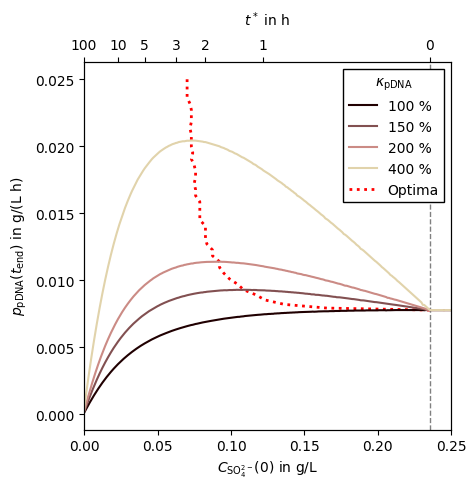

In [4]:
fig = plt.figure(dpi=100,figsize=(5,5))
fig.set_facecolor('w')
ax1 = fig.add_subplot(111)
ax1v2 = ax1.twiny()
for ax in [ax1,ax1v2]:
    ax.set_box_aspect(1)
#-----------#
#### AX1 ####
#-----------#

colors = ['#200001','#825051','#cb8b85','#e1d3ab','#f7f7e6']
optima_x = []
optima_y = []
optima_t = []
l = 0
for q_pDNA_max in q_pDNA_max_levels:
    endpoints          = processed[q_pDNA_max]
    S_0_array          = endpoints[:,0] * ecoli.metabolites.so4_e.formula_weight / 1000
    t_end_array        = endpoints[:,1]
    X_end_array        = endpoints[:,2]
    S_end_array        = endpoints[:,3] * ecoli.metabolites.so4_e.formula_weight / 1000
    P_end_array        = endpoints[:,4] * ecoli.metabolites.pDNA_c.formula_weight / 1000
    G_end_array        = endpoints[:,5] * ecoli.metabolites.glc__D_c.formula_weight / 1000
    t_star_start_array = t_end_array-endpoints[:,6]
    productivity = P_end_array/t_end_array

    if np.any([np.isclose(i,q_pDNA_max) for i in [.1/100,.15/100,.2/100,.4/100]]):
        ax1.plot(S_0_array,productivity,
                 color=colors[l],
                 label='{:3.0f} %'.format(q_pDNA_max/q_pDNA_min*100))
        l += 1
    optima_x.append(S_0_array[np.argmax(productivity)])
    optima_t.append(t_star_start_array[np.argmax(productivity)])
    optima_y.append(np.max(productivity))
    # find index of best process
    if np.isclose(q_pDNA_max,0.2/100):
        idx_optimum_zero_q_pDNA = np.argmax(productivity)
    
# plot optima and starvation cutoff
ax1.plot(optima_x,optima_y,zorder=-1,color='red',linestyle=':',label='Optima',linewidth=2)
# plot starvation cutoff
ylim = ax1.get_ylim()
t_star = optima_x[0]
ax1.plot([t_star]*2,ylim,zorder=-1,color='grey',linestyle='--',linewidth=1)
ax1.set_ylim(ylim)
# second X-axis
ax1.set_xlim(0,.25)
ax1_x2ticks = []
ax1_x2ticklabels = []
for i in np.array([100,10,5,3,2,1,0]):
    idx = np.argmin(np.abs(t_star_start_array-i))
    if i == 0:
        ax1_x2ticks.append(optima_x[0])
    else:
        ax1_x2ticks.append(S_0_array[idx])
    ax1_x2ticklabels.append(i)
ax1_x2ticklabels = ['100','10','5','3','2','1','0']
ax1v2.set_xticks(ax1_x2ticks)
ax1v2.set_xticklabels(ax1_x2ticklabels)
ax1v2.set_xlim(ax1.get_xlim())
ax1v2.set_xlabel(r'$t^*$ in h',labelpad=10)
ax1.set_xlabel(r'$C_{\rm SO_4^{2-}}(0)$ in g/L')
ax1.set_ylabel(r'$p_{\rm pDNA}(t_{\rm end})$ in g/(L h)')
ax1.legend(fancybox=False,edgecolor='k',loc='upper right',framealpha=1,title=r'$\kappa_{\rm pDNA}$')

plt.tight_layout()
plt.show()

# Figure S1

In [5]:
def plot_sol(sol):
    S_0 = sol[0] * ecoli.metabolites.so4_e.formula_weight / 1000    # mmol/L -> g/L
    t   = sol[1]                                                    # h
    X   = sol[2]                                                    # g
    S   = sol[3] * ecoli.metabolites.so4_e.formula_weight / 1000    # mmol/L -> g/L
    P   = sol[4] * ecoli.metabolites.pDNA_c.formula_weight / 1000   # mmol/L -> g/L
    G   = sol[5] * ecoli.metabolites.glc__D_e.formula_weight / 1000 # mmol/L -> g/L
    t_star_star = sol[6]                                            # h
    
    lines  = [X,P/X,P,S]
    colors = ['k','k','r','r']
    ylabs  = [r'$C_{\rm biomass}$ in g/L',r'$Y_{\rm pDNA/biomass}$ in g/g', r'$C_{\rm pDNA}$ in g/L', r'$C_{\rm SO_4^{2-}}$ in g/L']
    axes   = [ax2,ax3,ax2v2,ax3v2]

    for j in range(4):
        axes[j].plot(t,lines[j],label=r'$C_{\rm SO_4^{2-}}(t=0)$ ='+'{:6.3f}'.format(S_0)+' mmol/L',color=colors[j])
        axes[j].set_ylabel(ylabs[j],color=colors[j])
    return X,S,P,G,t,t[-1]

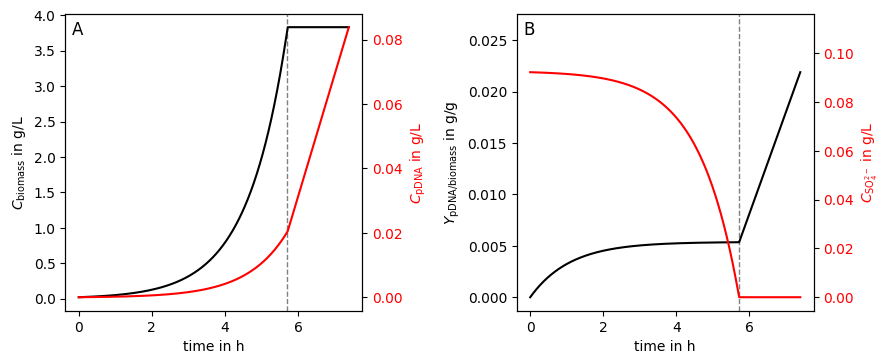

In [6]:
fig = plt.figure(dpi=100,figsize=(9,4.5))
fig.set_facecolor('w')
ax2 = fig.add_subplot(121)
ax3 = fig.add_subplot(122)
ax2v2 = ax2.twinx()
ax3v2 = ax3.twinx()
for ax in [ax2,ax3,ax2v2,ax3v2]:
    ax.set_box_aspect(1)



results = special_interest[.2/100]
for idx in [idx_optimum_zero_q_pDNA]:
    S_0 = list(results.keys())[idx]
    sol = results[S_0]
    X,S,P,G,t,t_end = plot_sol(sol)

for ax in [ax3,ax3v2]:
    tmp = ax.get_ylim()
    ax.set_ylim(np.array(tmp)*1.2)
    
for ax in [ax2,ax3]:
    ylim = ax.get_ylim()
    t_star = t[np.isclose(S,0,atol=1e-3)][0]
    ax.plot([t_star]*2,ylim,zorder=-1,color='grey',linestyle='--',linewidth=1)
    ax.set_ylim(ylim)
    
ax3.set_xlabel('time in h')
ax2.set_xlabel('time in h')
for ax in [ax2v2,ax3v2]:
    ax.tick_params(axis='y', labelcolor='red')
    
# label subpots
import matplotlib.transforms as mtransforms
for name, ax in zip(['A','B','C','D','E',],[ax2,ax3]):
    trans = mtransforms.ScaledTranslation(5/72, -5/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, name, transform=ax.transAxes + trans,
            fontsize='large', verticalalignment='top', fontfamily='sans',
            bbox=dict(facecolor='none', edgecolor='none', pad=3.0))


fig.align_ylabels()
fig.align_xlabels()
plt.tight_layout()
plt.show()